### Находим участки с __торможением__, __ускорением__ и __равномерной ездой__:

#### 1. Сначала импортируем модуль
```python
from src.utils import TSTrendEstimator
```
#### 2. Создаем датафрейм где указываем время, идентификатор авто и скорость
#### 3. Передаем эту таблицу в *TSTrendEstimator*
```python
result = TSTrendEstimator().fit_predict(df)
```
#### 4. Получаем *result*, где 
+ *X* это оригинальная скорость
+ *estimation* это оценка изменения скорости
+ *status*:
    + 1 это __ускорение__
    + 0 это __равномерная езда__
    + -1 это __торможение__

# 1. IMPORT 

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import src
from src.utils import TSTrendEstimator, plot_TSTrendEstimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# 2. LOAD DATA

In [23]:
#PATH = '/home/jovyan/remote_shared_data/dsdiag222/temporary/from_ntc_batching/2020_04_26_2020_06_30_valid_distance_upd.csv'

PATH = '/home/jovyan/remote_shared_data/dsdiag222/clipboard/2020_07_27_poligon_truck_vega_data.csv'
USECOLS = ['time', 'speed', 'car_vin']

In [24]:
%%time

df = pd.read_csv(PATH, usecols=USECOLS)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

CPU times: user 22.3 ms, sys: 13.1 ms, total: 35.4 ms
Wall time: 193 ms


### RESAMPLING

In [49]:
RESAMPLE_FREQ = '10s'

In [50]:
%%time

df_resampled = df.groupby('car_vin')['speed'].resample(RESAMPLE_FREQ).mean()
df_resampled.replace(0, np.nan, inplace=True)

CPU times: user 7.49 ms, sys: 0 ns, total: 7.49 ms
Wall time: 6.88 ms


In [52]:
# Input data example
df_resampled.dropna().head(20).to_frame()

speed
car_vin           time                          
XTC549015J2516693 2020-07-27 04:30:00   9.100000
                  2020-07-27 04:30:10  16.000000
                  2020-07-27 04:30:20  19.900000
                  2020-07-27 04:30:30  19.111111
                  2020-07-27 04:30:40  22.200000
                  2020-07-27 04:30:50  27.700000
                  2020-07-27 04:31:00  32.100000
                  2020-07-27 04:31:10  34.200000
                  2020-07-27 04:31:20  32.500000
                  2020-07-27 04:31:30  27.200000
                  2020-07-27 04:31:40  20.666667
                  2020-07-27 04:31:50  19.100000
                  2020-07-27 04:32:00  27.777778
                  2020-07-27 04:32:10  40.500000
                  2020-07-27 04:32:20  45.000000
                  2020-07-27 04:32:30  42.200000
                  2020-07-27 04:32:40  40.285714
                  2020-07-27 04:32:50  34.000000
                  2020-07-27 04:33:00  11.833333
                  2020-07-27 04:33:10  12.111111

# 3. TREND ESTIMATION

In [53]:
%time res = TSTrendEstimator(alpha=10, min_coef=-1, max_coef=1).fit_predict(df_resampled)

CPU times: user 349 ms, sys: 566 ms, total: 915 ms
Wall time: 97.6 ms


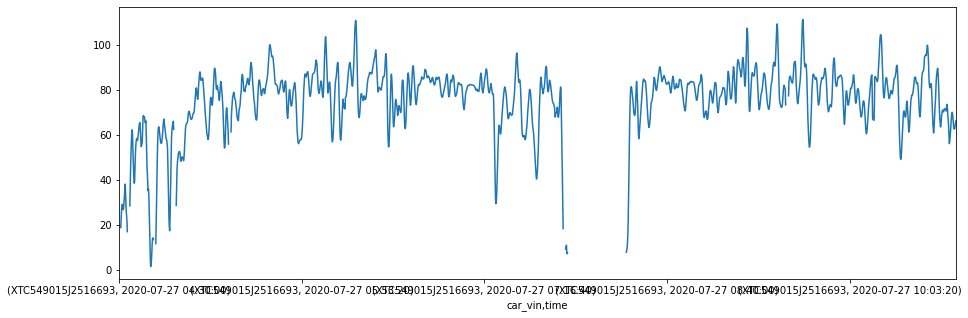

In [57]:
res['X'].plot(figsize=(15,5))

In [ ]:
def plot_TSTrendEstimation(df, value='X', coef='score', status='status', max_coef=1, min_coef=-1, n_lags=6):
   
    fig, axs = plt.subplots(2,1, sharex=True, figsize=(25,10))    

    for status, color in zip([0, -1, 1], ['green', 'blue', 'red']):

        mask = (df['status'] == status)
        
        ids = np.where(mask)[0]
        for i in range(n_lags):
            ids = np.unique(np.concatenate((ids, ids-i)))    
        max_id = mask.shape[0] - 1
        ids[ids < 0] = 0
        ids[ids > max_id] = max_id
        
        tmp = pd.Series(index=df.index)
        tmp.iloc[ids] = df.iloc[ids][value]
        tmp.plot(color=color, ax=axs[0], linewidth=5)
    
    axs[0].set_ylabel(value)

    
    df[coef].plot(ax=axs[1])
    axs[1].set_ylabel('coef')

    axs[1].axhline(y=0, color='r', linestyle='-', alpha=0.5)
    axs[1].axhline(y=min_coef, color='r', linestyle='--', alpha=0.25)
    axs[1].axhline(y=max_coef, color='r', linestyle='--', alpha=0.25) 

    plt.show()

In [14]:
# # Or for single car
# %time TSTrendEstimator().fit_predict(df_resampled.loc['XTC549015J2510673']).dropna()

CPU times: user 1.53 s, sys: 1.23 s, total: 2.76 s
Wall time: 231 ms


X  estimation  status
time                                              
2020-04-26 06:38:40  82.166667    9.515766     1.0
2020-04-26 06:38:50  82.000000    6.907658     1.0
2020-04-26 06:39:00  79.666667    3.805180     1.0
2020-04-26 06:39:10  76.333333    0.891892     0.0
2020-04-26 06:39:20  73.208333   -1.256757     0.0
...                        ...         ...     ...
2020-06-27 02:58:00  81.500000   -0.364114     0.0
2020-06-27 02:58:10  81.833333   -0.352853     0.0
2020-06-27 02:58:20  82.250000   -0.157658     0.0
2020-06-27 02:58:30  83.361111    0.187312     0.0
2020-06-27 02:58:40  84.152778    0.503754     0.0

[120887 rows x 3 columns]

# 4. RESULT

In [141]:
tmp = df_resampled.loc['XTC549015J2516693']

In [ ]:
tmp.rolling()

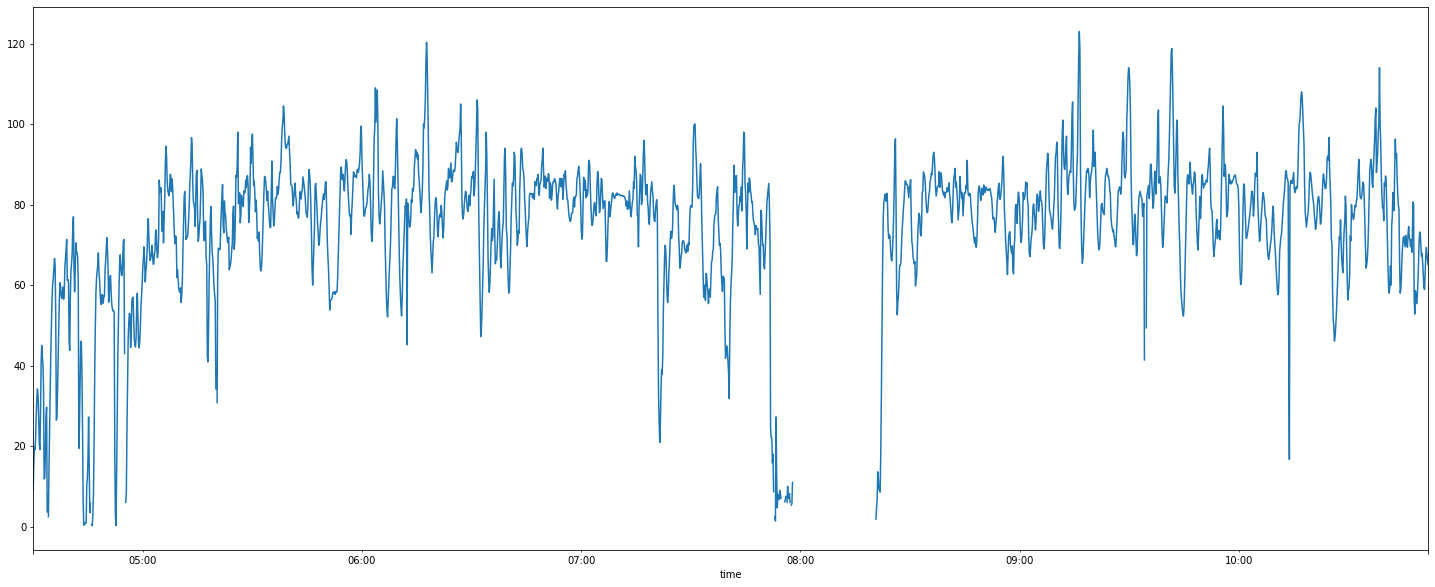

In [162]:
df_resampled.loc['XTC549015J2516693'].plot(figsize=(25,10))

In [236]:
tmp = df_resampled.loc['XTC549015J2516693'].rolling('600s').mean()

In [248]:
import numpy
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=numpy.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=numpy.ones(window_len,'d')
        else:  
                w=eval('numpy.'+window+'(window_len)')
        y=numpy.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

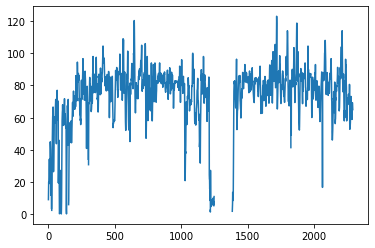

In [254]:
plt.plot(df_resampled.values)

In [259]:
plt.plot(smooth(df_resampled.values, window=21))

ValueError: Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'

In [555]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl
    
    
class TSSplineEstimator(ClusterMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X, k=0.1):
        series = X.copy()
        minutes = int((X.index.max() - X.index.min()).seconds/60)
        
        y = series.fillna(0).values
        x = np.arange(len(y))
        
        spline = get_natural_cubic_spline_model(x, y, minval=0, maxval=max(x), n_knots=int(minutes*k)).predict(x)
        spline = pd.Series(spline, index=series.index)
        score = spline.diff()
        
        return score

In [554]:
ts = df_resampled.loc['XTC549015J2516693']

In [553]:
def plot_trend(ts, score, upper_bound=0.5, lower_bound=-0.5):
    plt.figure(figsize=(25,5))

    s = ts.copy()
    s.loc[score > lower_bound] = np.nan
    s.plot(color='blue')

    s = ts.copy()
    s.loc[score < upper_bound] = np.nan
    s.plot(color='red')

    s = ts.copy()
    s.loc[(score > upper_bound) + (score < lower_bound)] = np.nan
    s.plot(color='green')
    
    plt.show()


In [ ]:
ts = df_resampled.loc['XTC549015J2516693'].rolling(5).mean()
plot_trend(ts, TSTrendEstimator2().predict(ts, k=0.4))

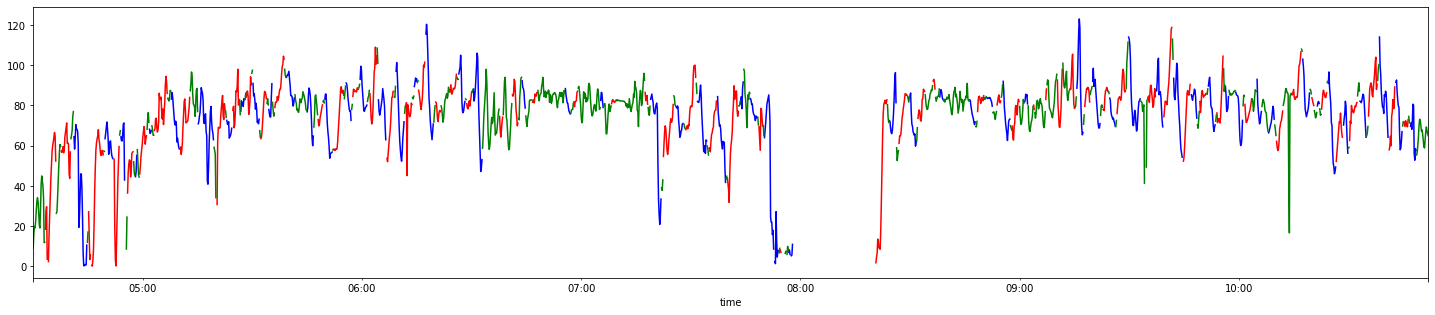

In [551]:
score = TSTrendEstimator2().predict(ts, k=0.55)
tmp = df_resampled.loc['XTC549015J2516693']

upper_bound = 0.5
lower_bound = -0.5

plt.figure(figsize=(25,5))

s = ts.copy()
s.loc[score > lower_bound] = np.nan
s.plot(color='blue')

s = ts.copy()
s.loc[score < upper_bound] = np.nan
s.plot(color='red')

s = ts.copy()
s.loc[(score > upper_bound) + (score < lower_bound)] = np.nan
s.plot(color='green')


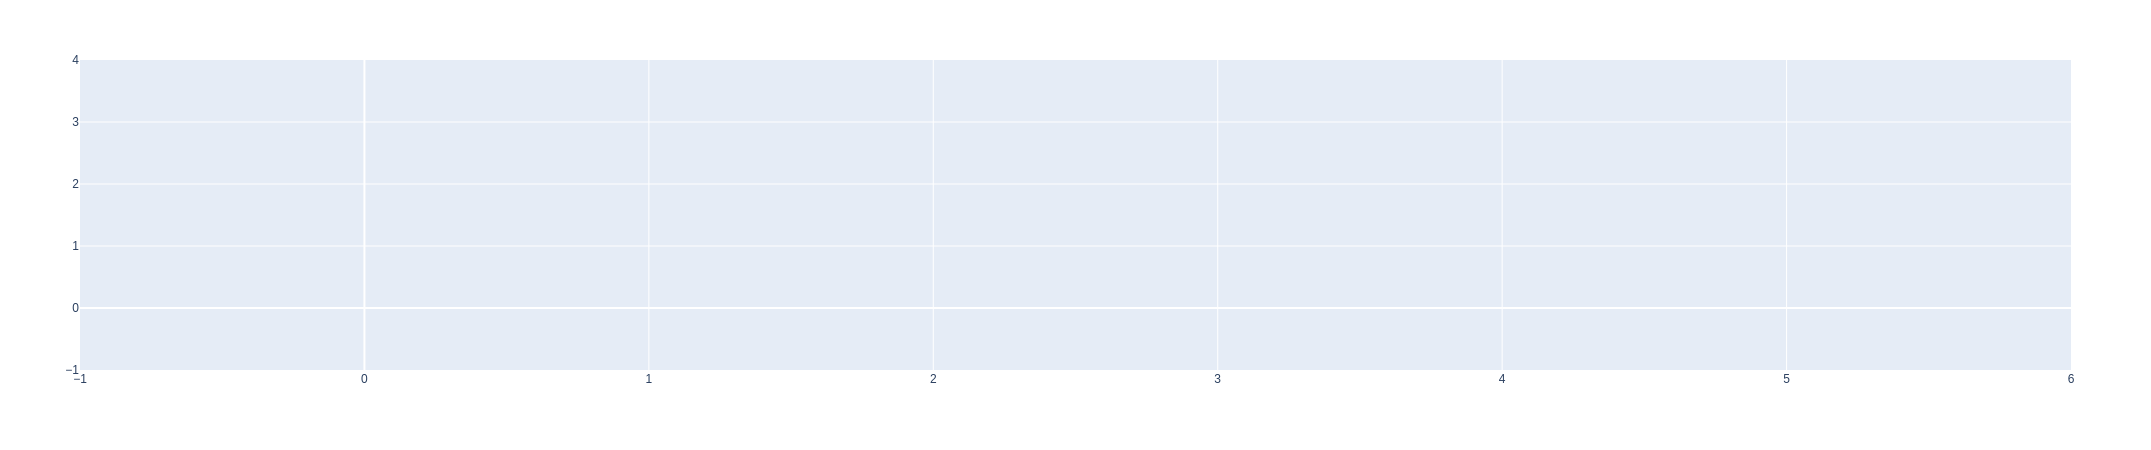

In [471]:
px.line(tmp[['ts', 'color']], color='color')

In [459]:
tmp['color'] = tmp['score'].apply(lambda x: {0:'green', 1:'red', -1:'blue'}[x])

In [463]:
tmp['color'].value_counts()

red      1168
blue     1123
green       1
Name: color, dtype: int64

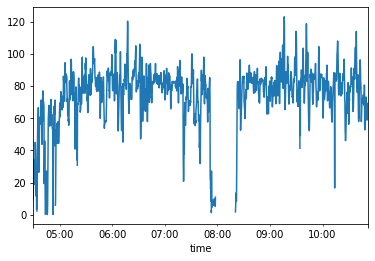

In [467]:
tmp['ts'].plot()

In [319]:
t = (df_resampled.loc['XTC549015J2516693'].index.max() - df_resampled.loc['XTC549015J2516693'].index.min())

seconds = t.seconds
minutes = int(seconds/60)

In [322]:
y = df_resampled.loc['XTC549015J2516693'].fillna(0).values
x = np.arange(len(y))

model = 

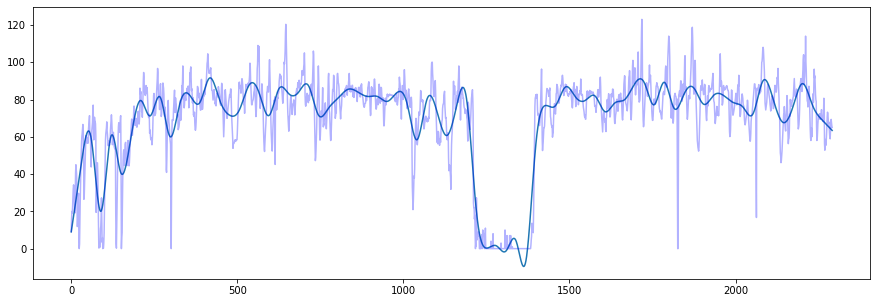

In [327]:
plt.figure(figsize=(15,5))

plt.plot(get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=int(minutes/5)).predict(x))
plt.plot(y, alpha=0.3, color='blue')

In [345]:
pred = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=int(minutes/5)).predict(x)
pred = pd.Series(pred, tmp.index)

In [385]:
mask_pos = pred.diff() > 0
mask_neg = pred.diff() <= 0

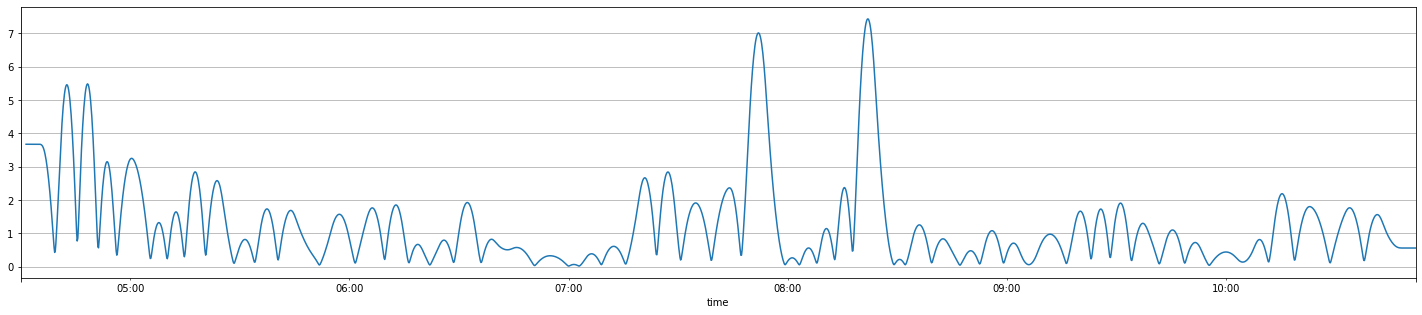

In [388]:
pred.rolling(10).std().plot(figsize=(25,5))
plt.grid()

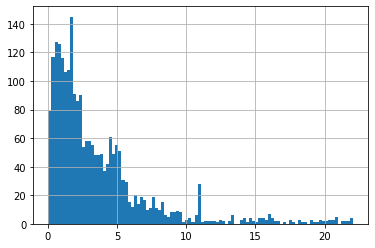

In [419]:
(pred.rolling(10).max() - pred.rolling(10).min()).hist(bins=100)

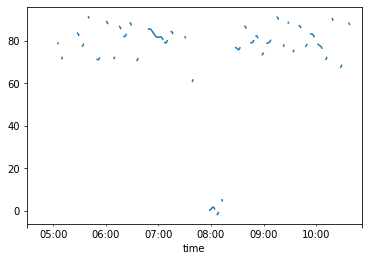

In [416]:
mask_norm =  (pred.rolling(10).max() - pred.rolling(10).min() <= 5)
s.loc[~mask_norm] = np.nan
s.plot()

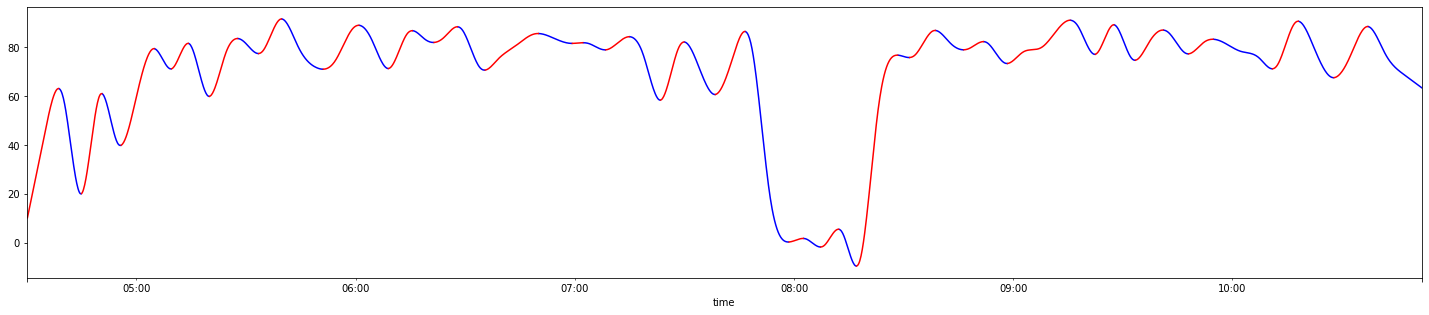

In [387]:
plt.figure(figsize=(25,5))

s = pred.copy()
s.loc[~mask_neg] = np.nan
s.plot(color='blue')

s = pred.copy()
s.loc[~mask_pos] = np.nan
s.plot(color='red')

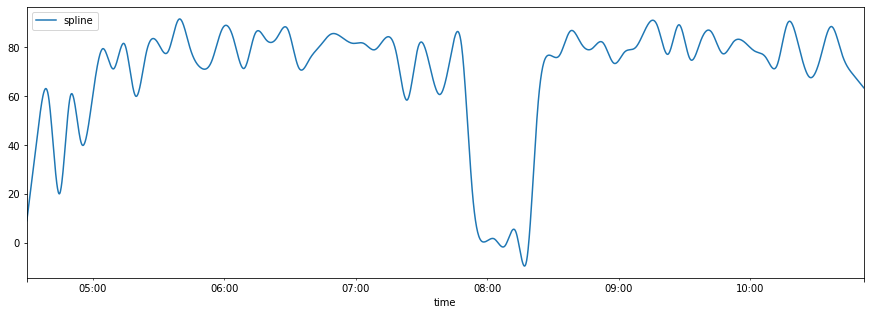

In [338]:
pred.plot(figsize=(15,5))

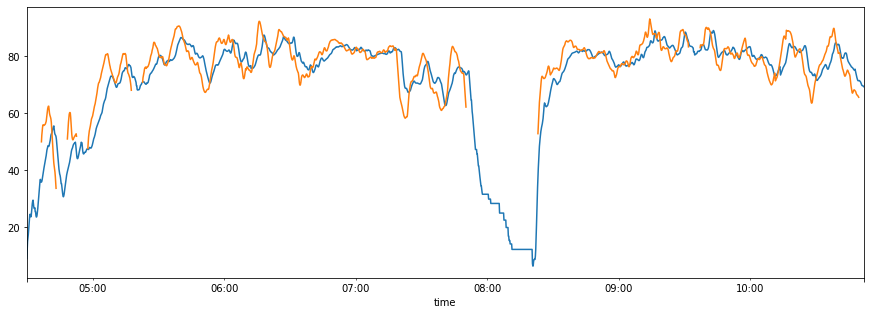

In [315]:
df_resampled.loc['XTC549015J2516693'].ewm(30, ).mean().plot(figsize=(15,5))
df_resampled.loc['XTC549015J2516693'].rolling(30, center=True).mean().plot(figsize=(15,5))

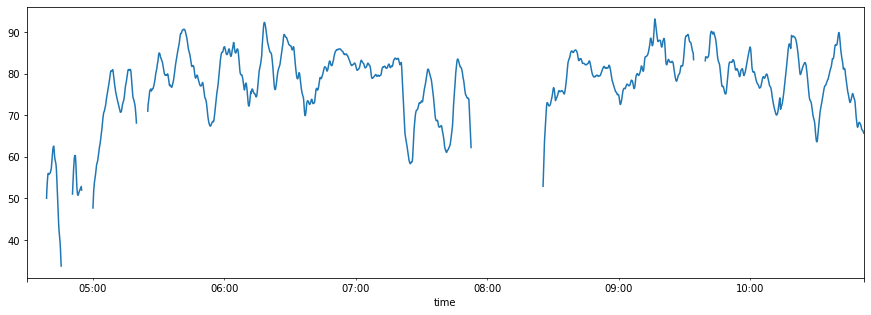

In [267]:
df_resampled.loc['XTC549015J2516693'].rolling(30).mean().plot(figsize=(15,5))

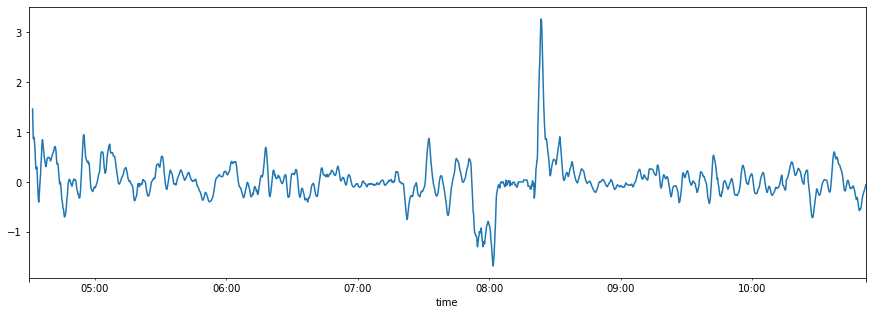

In [243]:
tmp.diff().rolling(10).mean().plot(figsize=(15,5))
plt.show()

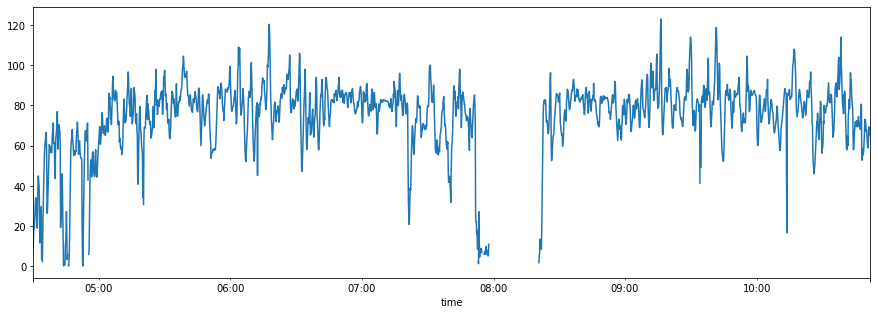

In [246]:
df_resampled.loc['XTC549015J2516693'].plot(figsize=(15,5))
plt.show()

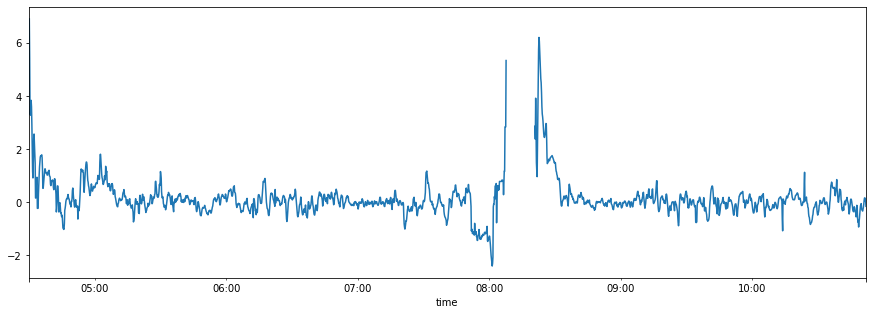

In [231]:
tmp.plot(figsize=(15,5))

In [232]:
tmp

time
2020-07-27 04:30:00         NaN
2020-07-27 04:30:10    6.900000
2020-07-27 04:30:20    5.400000
2020-07-27 04:30:30    3.337037
2020-07-27 04:30:40    3.275000
                         ...   
2020-07-27 10:51:10    0.153333
2020-07-27 10:51:20    0.160556
2020-07-27 10:51:30    0.046667
2020-07-27 10:51:40    0.098333
2020-07-27 10:51:50   -0.159259
Freq: 10S, Name: speed, Length: 2292, dtype: float64

In [223]:
window = 10
mask = (tmp.diff() > 0).rolling(window).mean()
mask_pos = (mask > 0)
mask_neg = (mask < 0)

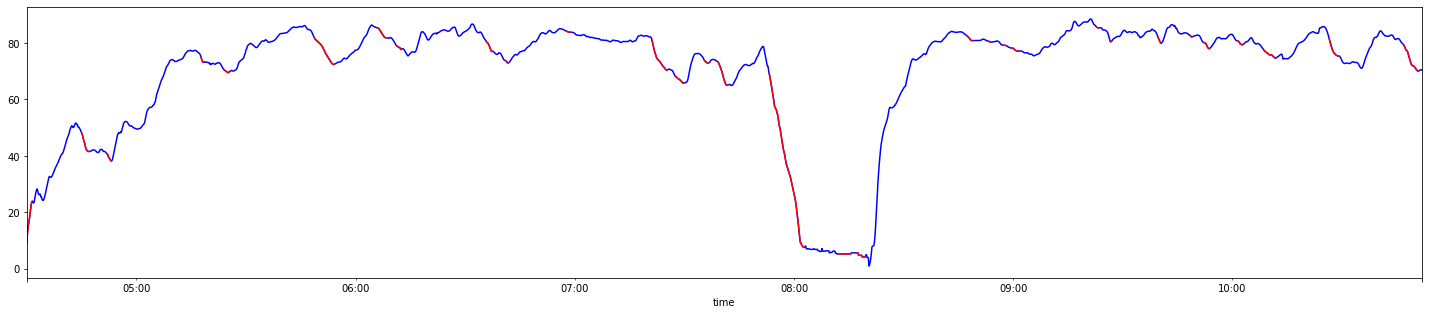

In [224]:
plt.figure(figsize=(25,5))

s = tmp.copy()
s.loc[mask_neg] = np.nan
s.plot(color='blue')

s = tmp.copy()
s.loc[mask_pos] = np.nan
s.plot(color='red')

### 

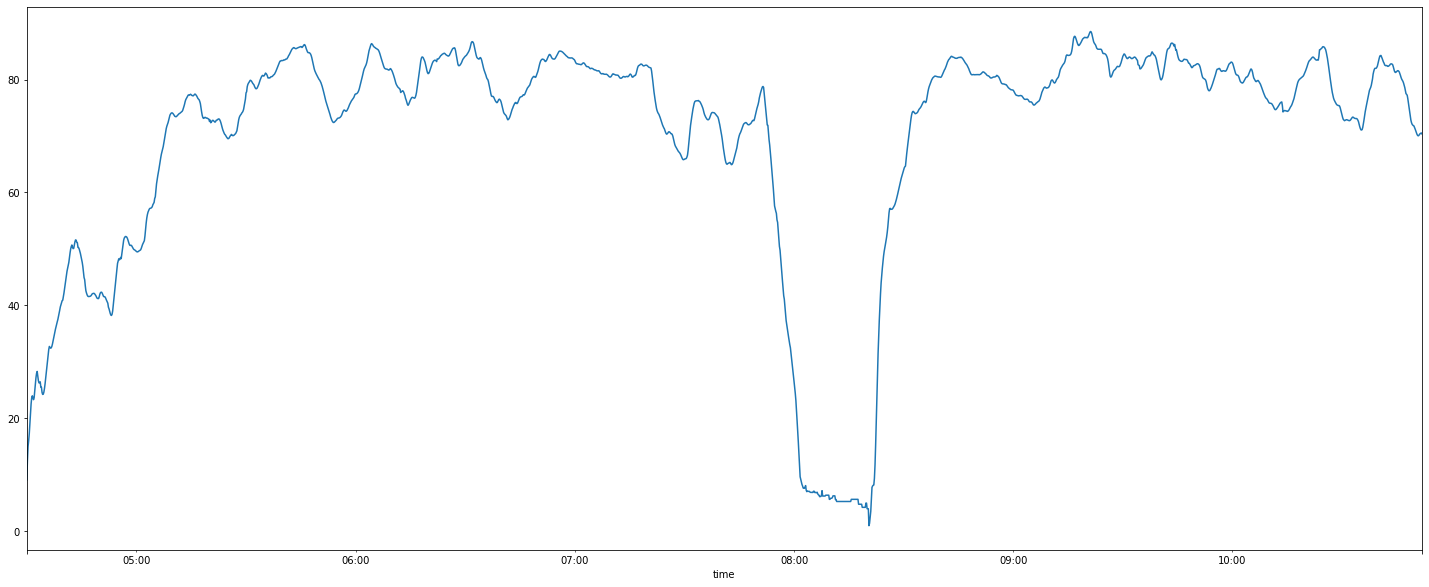

In [164]:
df_resampled.loc['XTC549015J2516693'].rolling('600s').mean().plot(figsize=(25,10))

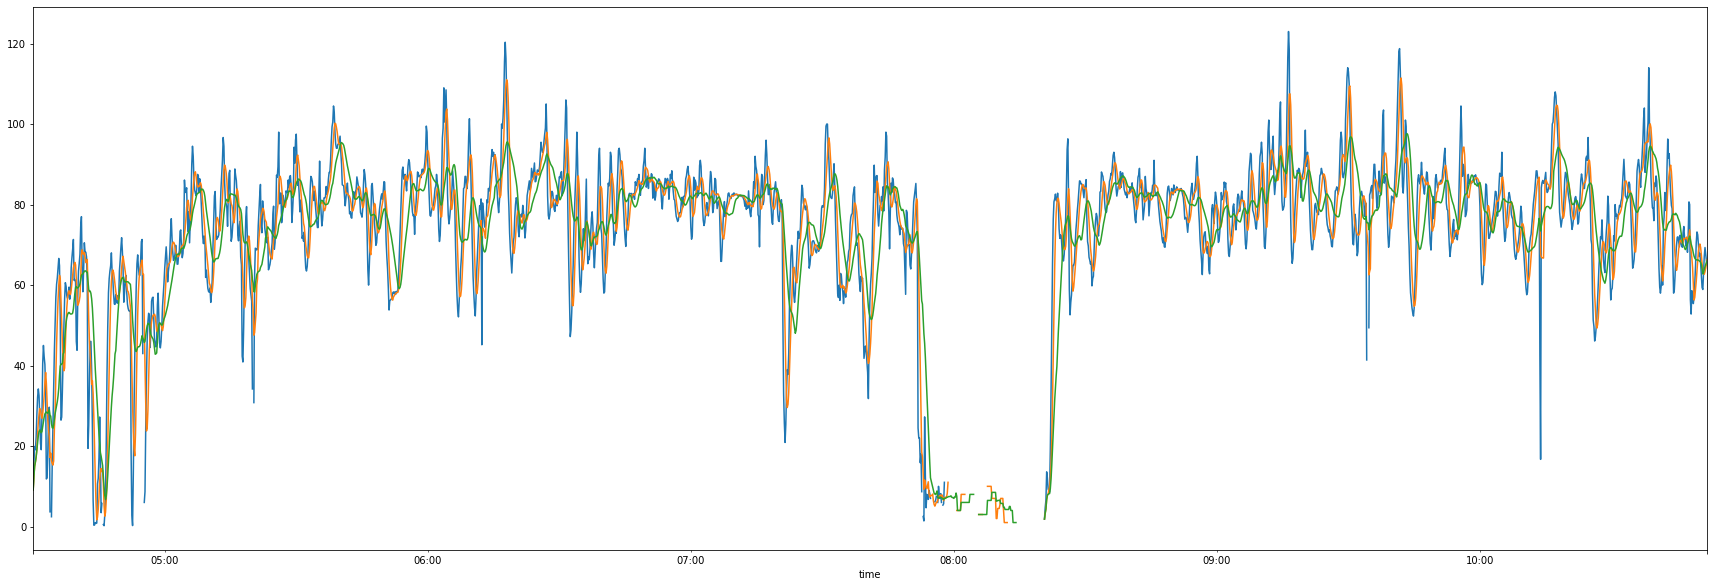

In [155]:
plt.figure(figsize=(30,10))
for window in [10, 60, 180]:
    
    tmp.rolling(str(window)+'s').mean().plot()
plt.show()

In [122]:
vin_list = df['car_vin'].unique()
%time res = TSTrendEstimator(alpha=0, min_coef=-0.25, max_coef=0.25).fit_predict(df_resampled)

CPU times: user 275 ms, sys: 258 ms, total: 533 ms
Wall time: 72.7 ms


XTC549015J2516693


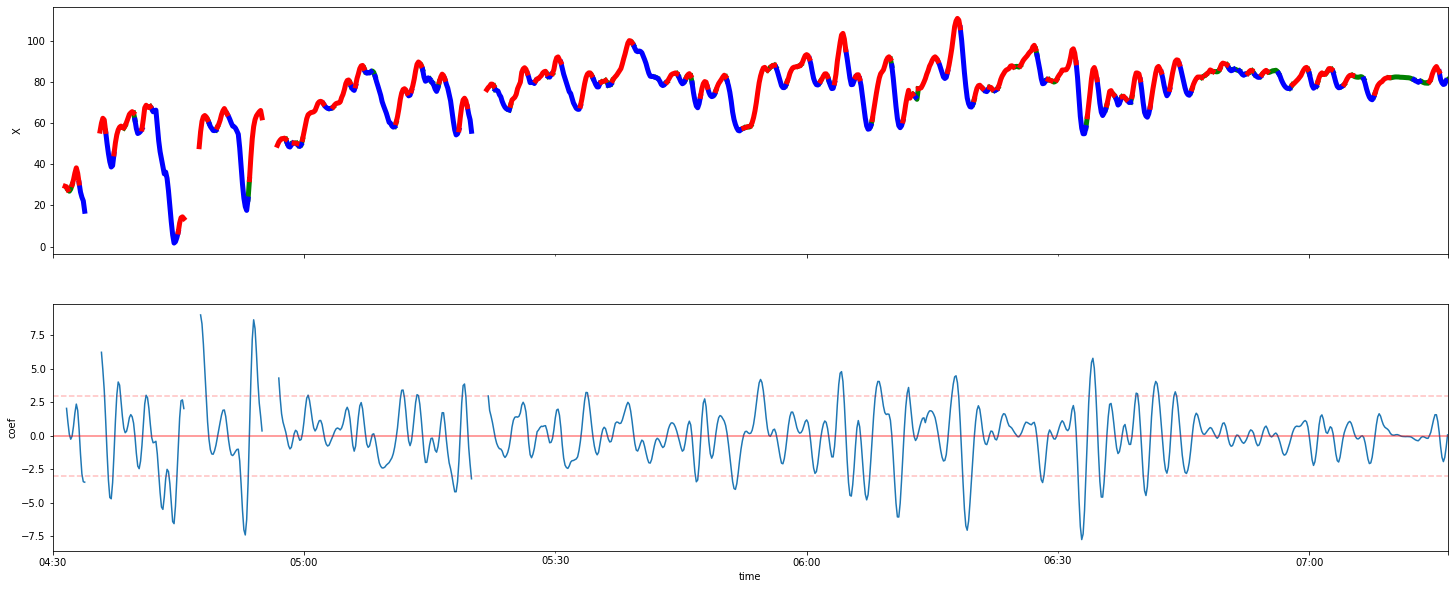

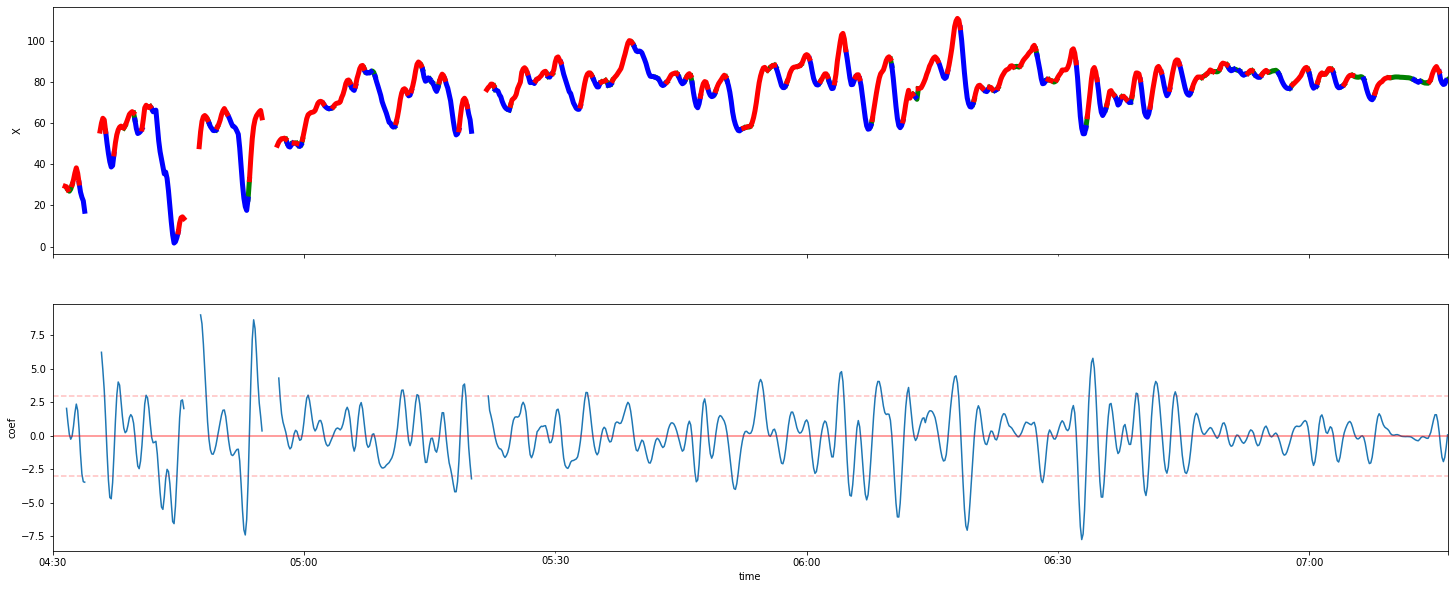

In [138]:
res['score_roll'] = res['score'].rolling(2).mean()
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2, status='status_diff')
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2)

In [136]:
res['status_diff'] = res['score'].diff()

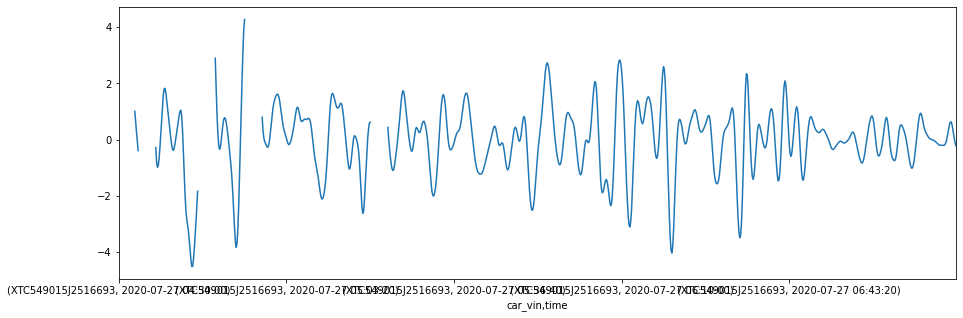

In [128]:
res['score'].rolling(10).mean().head(1_000).plot(figsize=(15,5))

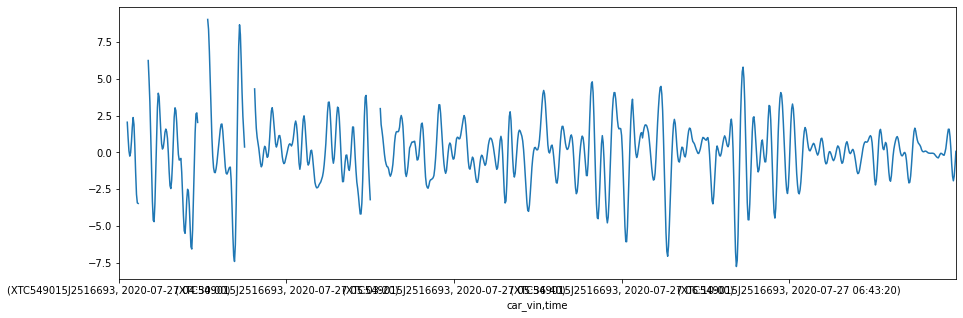

In [126]:
res['score'].head(1_000).plot(figsize=(15,5))

XTC549015J2516693


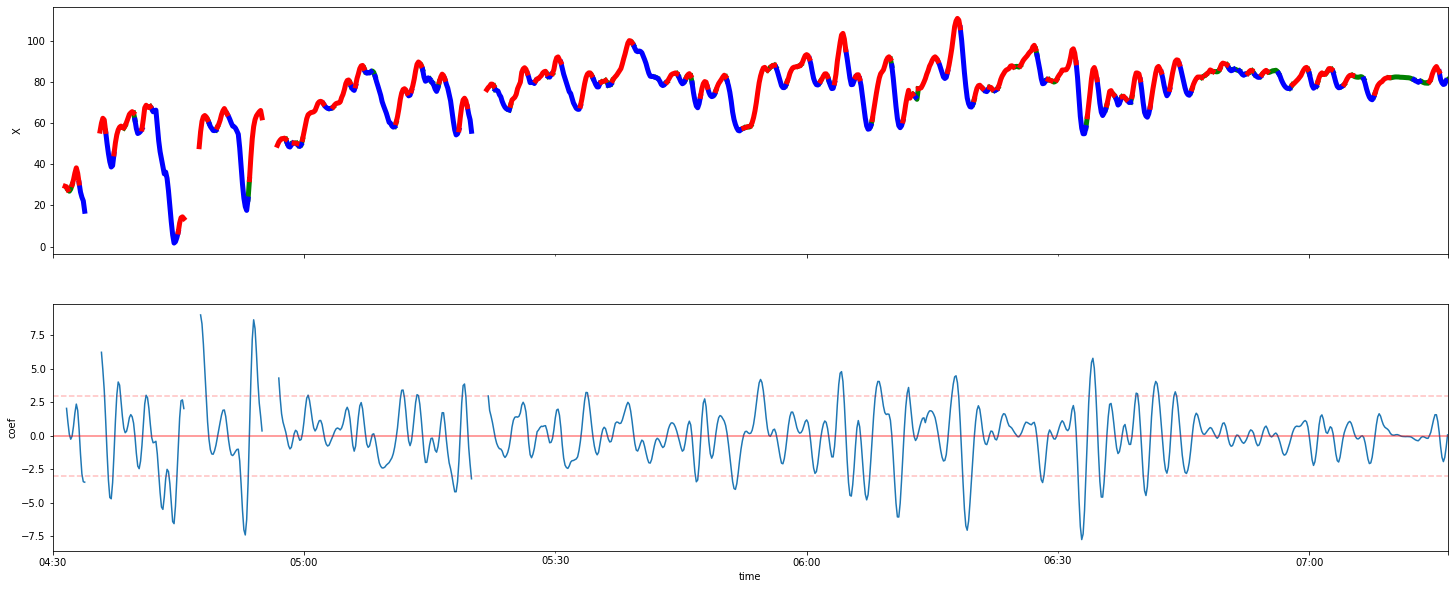

In [91]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2)

# FFT

In [99]:
from scipy import fft

In [106]:
fft(df_resampled.values)

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

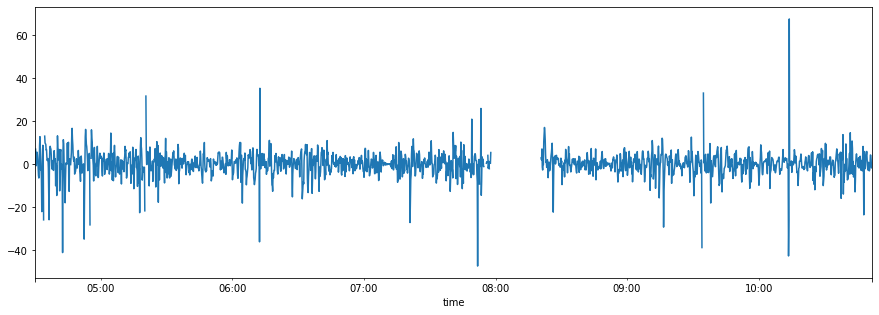

In [112]:
df_resampled.loc['XTC549015J2516693'].diff().plot(figsize=(15,5))

In [103]:
fft(df_resampled.loc['XTC549015J2516693'])

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

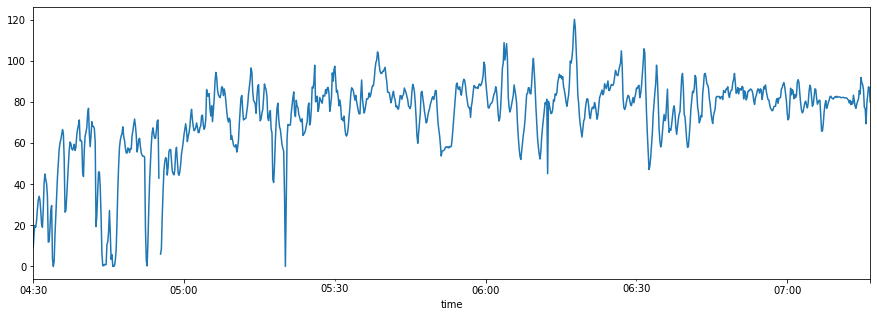

In [120]:
df['speed'].resample('10s').mean().head(1_000).plot(figsize=(15,5))

# STASH

In [183]:
rand_vin = np.random.choice(vin_list)

In [184]:
df_orig = df.loc[rand_vin]
df_score = res.loc[rand_vin]
tmp = pd.merge_asof(df_orig, df_score, left_index=True, right_index=True)

XTC549015K2520656


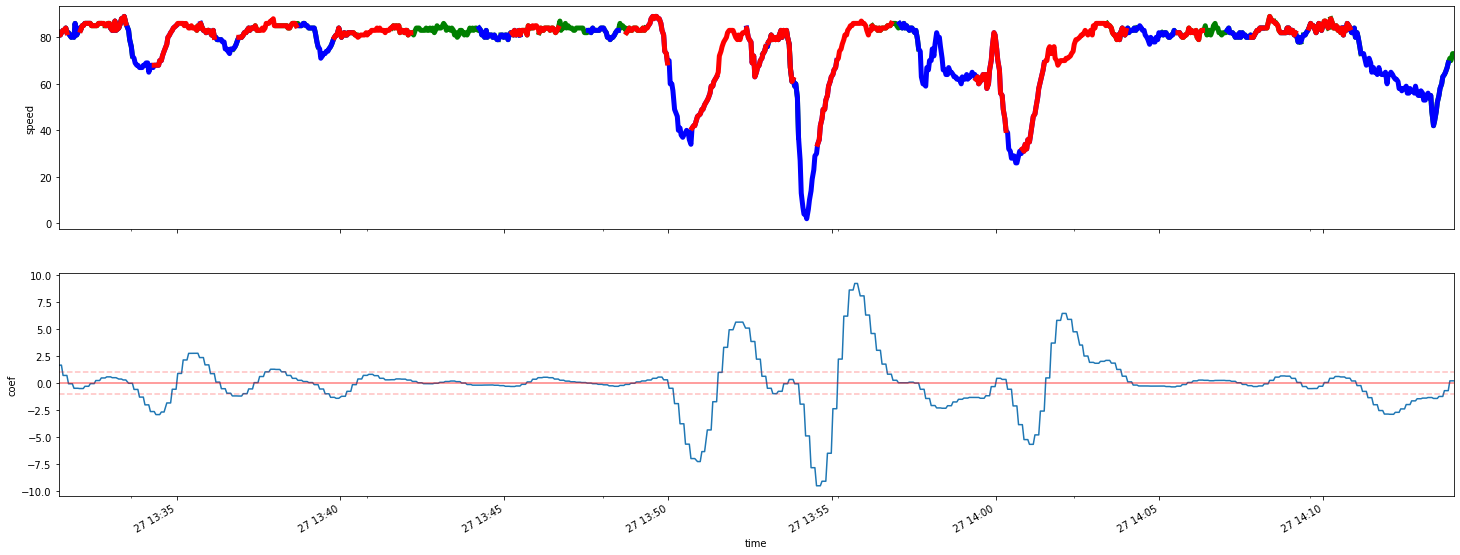

In [223]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(tmp.head(5_000).tail(1_000), value='speed', max_coef=1, min_coef=-1, n_lags=6)